In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import skimage.io
from skimage import filters
from skimage.color import rgb2gray
from skimage.filters import window, difference_of_gaussians

import scipy
from math import ceil

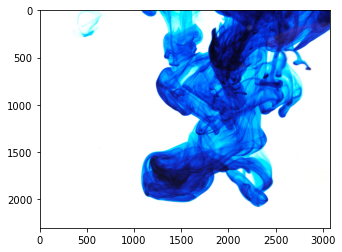

In [2]:
frame = skimage.io.imread('fluid.jpg')

plt.imshow(frame)
plt.show()

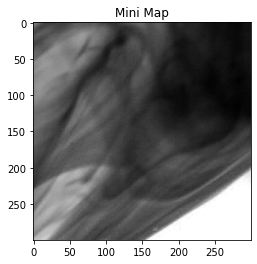

In [3]:
img1 = rgb2gray(frame[:300,-300:,::-1])
plt.title('Mini Map')
plt.imshow(img1,cmap='gray')
plt.show()

In [4]:
def shift_images(shift_x,shift_y,frame,dim,x0,y0):
    """
    shift_x,shift_y = how much shift to apply
    frame (full image)
    dim = dimension of the cropped window
    x0,y0 = specify the starting coord
    returns an image list that is shifted by shift_x and shift_y
    returns a list of coord tuples (lower left coord, dim) of the shifted image frame corresponding to image list
    """
    frame_grey = rgb2gray(frame)
    nrow,ncol = frame_grey.shape
    y0_new = y0
    x0_new = x0
    image_frames = []
    coord_list = []
    while (y0_new + dim < nrow) and (x0_new + dim < ncol):
        img = frame_grey[y0_new:y0_new+dim,x0_new:x0_new+dim]
        image_frames.append(img)
        coord_list.append(((x0_new,y0_new+dim),dim))
        y0_new += shift_y
        x0_new += shift_x

    return image_frames, coord_list

image_frames, coord_list = shift_images(shift_x=0,shift_y=10,frame=frame,dim=300,x0=1500,y0=0)

In [6]:
len(image_frames[::10])
coord_list[:10]

[((1500, 300), 300),
 ((1500, 310), 300),
 ((1500, 320), 300),
 ((1500, 330), 300),
 ((1500, 340), 300),
 ((1500, 350), 300),
 ((1500, 360), 300),
 ((1500, 370), 300),
 ((1500, 380), 300),
 ((1500, 390), 300)]

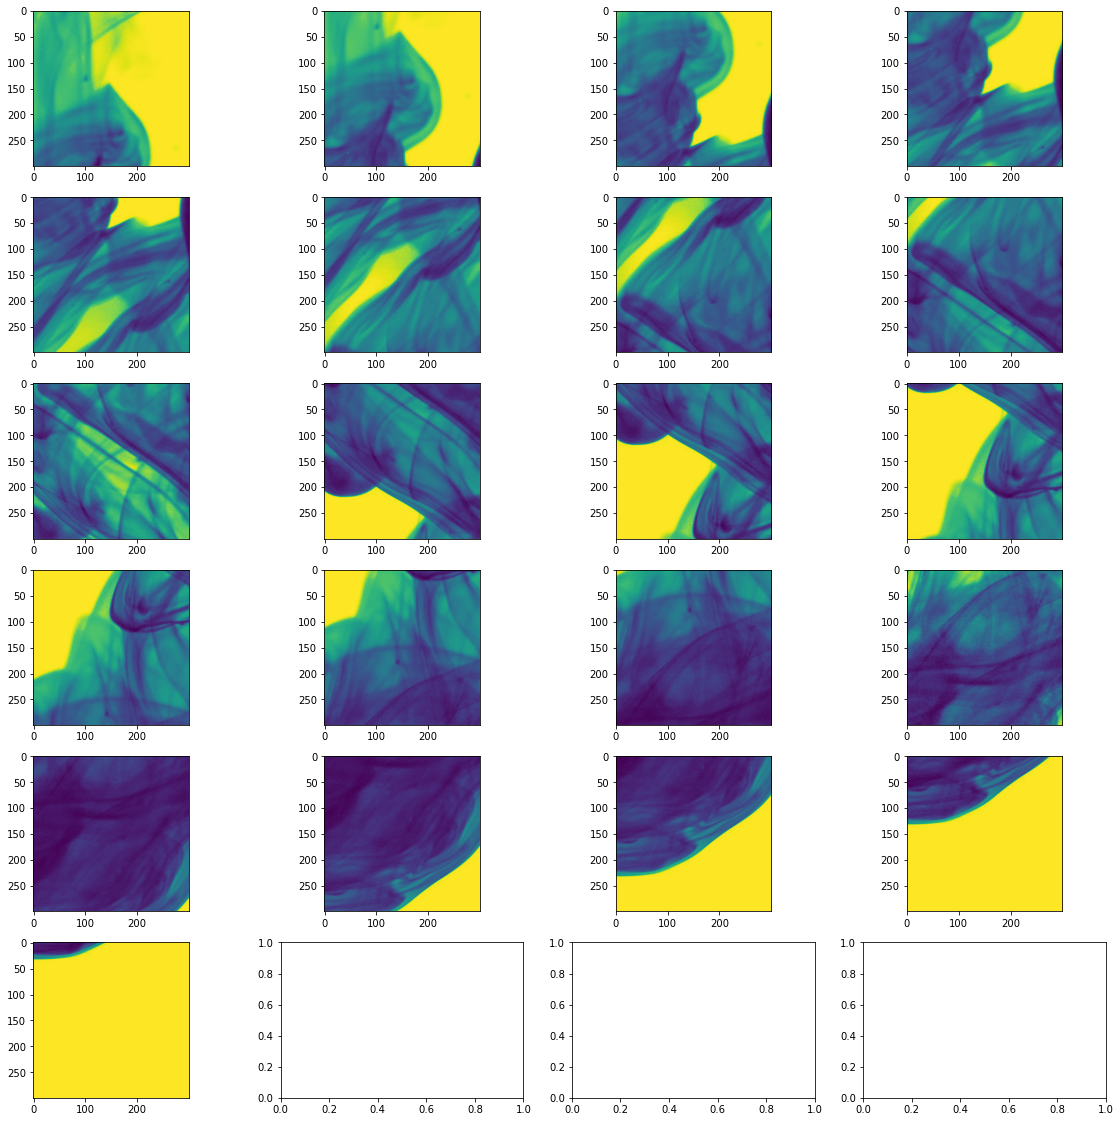

In [7]:
fig,axes = plt.subplots(ceil(len(image_frames[::10])/4),4,figsize=(20,20)) # plot every 10 image
for ax, im in zip(axes.flatten(),image_frames[::10]):
    ax.imshow(im)

plt.show()

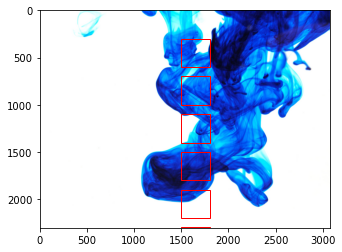

In [43]:
fig,ax = plt.subplots()
ax.imshow(frame)
for (x,y),w in coord_list[::40]:
    ax.add_patch(Rectangle((x,y),w,w,
                    edgecolor='red',
                    facecolor='none',
                    lw=1))

plt.show()

In [8]:
im_stack = np.stack(image_frames,axis=2)
im_stack.shape

(300, 300, 201)

In [74]:
def differential_intensity(im_stack):
    """
    im_stack (np.array): a tensor where the row and col is the spatial image, and depth is the image taken diff time instance
    axis (int): 0 (nrow), 1 (ncol), 2 (time)
    This function finds the mean difference across an axis
    e.g. finding the mean difference across the x-axis means taking a mean of slice (x) of the column, and minusing the mean of slice (x-1) of the column
    """
    nrow,ncol,t = im_stack.shape
    Iy = np.zeros(nrow-1)
    Ix = np.zeros(ncol-1)
    It = np.zeros(t-1)
    
    for i in range(1,nrow):
        Iy[i-1] = np.mean(im_stack[i,:,:]) - np.mean(im_stack[i-1,:,:])

    for i in range(1,ncol):
        Ix[i-1] = np.mean(im_stack[:,i,:]) - np.mean(im_stack[:,i-1,:])

    for i in range(1,t):
        It[i-1] = np.mean(im_stack[:,:,i]) - np.mean(im_stack[:,:,i-1])

    return Iy, Ix, It

In [94]:
Iy, Ix, It = differential_intensity(im_stack)

In [9]:
def lucas_kanade(I1g, I2g, window_size, tau=1e-2):
    """
    I1 and I2 are two images taken at times t = 1 and t = 2 respectively,
    u and v are the x and y components of the optical flow,
    window_size is a 1 x 2 vector storing the width and height of the window used during flow computation.
    a theshold τ should be added, such that if τ is larger than the smallest eigenvalue of ATA, then the the optical flow at that position should not be computed. 
    Recall that the optical flow is only valid in regions where AtA has rank 2
    The following figure describes the algorithm, which considers a nxn (n>=3) window around each pixel and 
    solves a least-square problem to find the best flow vectors for the pixel.
    https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/
    """
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = scipy.signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode) #compute gradient across the x axis through convolving, works the same as taking one column - adjacent column
    fy = scipy.signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode) #compute gradient across the y axis
    ft = scipy.signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + scipy.signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    #compute gradient across the t axis
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w): #iterate across rows
        for j in range(w, I1g.shape[1]-w): #iterate across columns
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = It
            At = np.array([Iy,Ix])
            A = np.transpose(At)
            AtA = np.dot(At,A)
            AtA_det = np.linalg.det(AtA) #calculate determinant of AtA to make sure that AtA is invertible, aka det(AtA)=/=0
            if AtA_det == 0.0:
                u[i,j]=0
                v[i,j]=0
                continue
            else:
                AtB = np.dot(At,b)
                AtA_inverse = np.linalg.pinv(AtA)
                nu = np.dot(AtA_inverse,AtB)
                eig = np.linalg.eig(AtA)
                if tau > np.min(eig[0]): #OF should not be computed
                    u[i,j]=0
                    v[i,j]=0
                #b = ... # get b here
                #A = ... # get A here
                # if threshold τ is larger than the smallest eigenvalue of A'A:
                # nu = ... # get velocity here
                else:
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
 
    return u,v

In [10]:
u,v = lucas_kanade(im_stack[:,:,0], im_stack[:,:,1], 10, tau=1e-6)

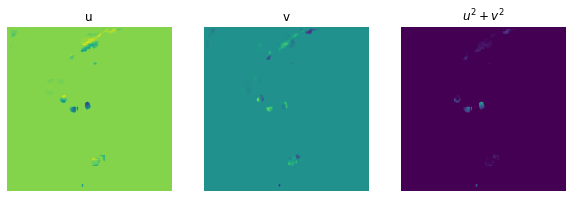

In [13]:
def plot_u_v(u,v):
    fig, ax = plt.subplots(1,3,figsize=(10,15))
    ax[0].imshow(u)
    ax[1].imshow(v)
    ax[2].imshow(u**2 + v**2)

    for a,labels in zip(ax.flatten(),['u','v',r'$u^2 + v^2$']):
        a.axis('off')
        a.set_title(labels)
    return

plot_u_v(u,v)
    

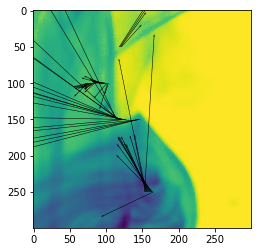

In [16]:
plt.figure()
plt.imshow(im_stack[:,:,0])
X,Y = np.meshgrid(list(range(300)),list(range(300)))
plt.quiver(X[::50],Y[::50],u[::50],v[::50],minshaft = 1, minlength=0)
# plt.quiver(X,Y,u,v,minshaft = 1, minlength=0)
plt.show()

# Animate frame

......Done!


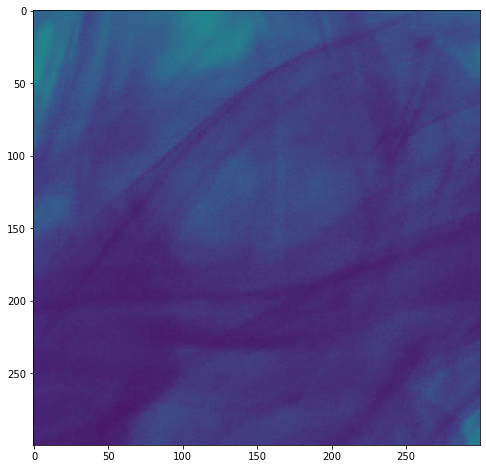

In [5]:
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation

def animate_frames(image_frames,fname,fps=30,nSeconds=5):
    """
    fps = frame per second
    nSeconds = length of video
    image_frames (list of np arrays): containing the temporal sequence
    """

    snapshots = image_frames#[ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = image_frames[0]
    im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(image_frames[i])
        return [im]

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * fps,
                                interval = 1000 / fps, # in ms
                                )

    anim.save('{}.mp4'.format(fname), fps=fps, extra_args=['-vcodec', 'libx264'])

    print('Done!')
    return

animate_frames(image_frames,fname='shifted_fluid',fps=30,nSeconds=5)

# Perform Lucas Kanade OF for all images

In [ ]:
u,v = lucas_kanade(im_stack[:,:,0], im_stack[:,:,1], 10, tau=1e-6)